In [ ]:
#!pip install numpy scipy pandas matplotlib numba arviz tabulate seaborn tqdm

In [ ]:
#!pip install lifetimes --quiet

In [1]:
# Imports & settings
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import arviz as az
from tabulate import tabulate      # purely for pretty tables in the notebook

from abe_hb_pareto_nbd import AbeHBParetoNBD, load_cdnow

[AbeHB] Numba JIT backend active.


In [2]:
# Load CDNOW and inspect
customers, cov = load_cdnow()      # will download once to ~/.cache
N = len(customers)
print(f"{N} customers in calibration window")

cov.head()

23570 customers in calibration window


,id,intercept,init_amount
0,00001,1.0,11.77
1,00002,1.0,12.00
2,00003,1.0,20.76
3,00004,1.0,29.33
4,00005,1.0,29.33


In [ ]:
# Fit the non-HB Pareto/NBD baseline
from lifetimes import ParetoNBDFitter
from datetime import timedelta

# ---- prepare the CDNOW calibration RFM table ---------------------------
txn = pd.read_csv(
    "~/.cache/cdnow_master.txt",
    sep=r"\s+",
    header=0,
    names=["id", "date", "qty", "spend"],
    parse_dates=["date"],
)
txn["t_week"] = (txn["date"] - txn.groupby("id")["date"].transform("min")).dt.days / 7

calib_weeks = 39
calib_end   = txn["t_week"] <= calib_weeks

summary = (
    txn[calib_end]
        .groupby("id")
        .agg(
            frequency = ("id", lambda x: len(x)-1),
            recency   = ("t_week", "max"),
            T         = ("t_week", lambda x: calib_weeks),
        )
)

# ---- fit population Pareto/NBD -----------------------------------------
pnbd = ParetoNBDFitter(penalizer_coef=0.0)
pnbd.fit(summary["frequency"], summary["recency"], summary["T"])

<lifetimes.ParetoNBDFitter: fitted with 23570 subjects, alpha: 10.95, beta: 4.29, r: 0.62, s: 0.36>

In [3]:
# Fit the HB Pareto/NBD
model = AbeHBParetoNBD(customers, seed=42)
model.run_mcmc(
    n_iter   = 14_000,   # total
    burn_in  = 10_000,   # first part discarded
    thin     = 1,        # keep every post–burn-in draw
    proposal_scale = 0.25,
)

[AbeHB] Running chain with Numba backend.
[AbeHB] Starting MCMC: 14,000 iterations (burn‑in 10,000, thin 1) on 23,570 customers.


MCMC:   7%|▋         | 1011/14000 [00:11<02:18, 93.96it/s]

iter   1000  acceptance ≈ 0.704


MCMC:  14%|█▍        | 2011/14000 [00:22<02:07, 93.84it/s]

iter   2000  acceptance ≈ 0.706


MCMC:  22%|██▏       | 3011/14000 [00:32<01:57, 93.50it/s]

iter   3000  acceptance ≈ 0.707


MCMC:  29%|██▊       | 4011/14000 [00:43<01:46, 93.87it/s]

iter   4000  acceptance ≈ 0.707


MCMC:  36%|███▌      | 5011/14000 [00:54<01:37, 92.35it/s]

iter   5000  acceptance ≈ 0.707


MCMC:  43%|████▎     | 6014/14000 [01:05<01:27, 91.41it/s]

iter   6000  acceptance ≈ 0.707


MCMC:  50%|█████     | 7014/14000 [01:16<01:14, 93.46it/s]

iter   7000  acceptance ≈ 0.706


MCMC:  57%|█████▋    | 8013/14000 [01:28<01:05, 91.73it/s]

iter   8000  acceptance ≈ 0.707


MCMC:  64%|██████▍   | 9009/14000 [01:38<00:53, 93.87it/s]

iter   9000  acceptance ≈ 0.707


MCMC:  72%|███████▏  | 10012/14000 [01:50<00:45, 88.47it/s]

iter  10000  acceptance ≈ 0.707


MCMC:  79%|███████▊  | 11013/14000 [02:00<00:30, 98.70it/s]

iter  11000  acceptance ≈ 0.707


MCMC:  86%|████████▌ | 12013/14000 [02:11<00:20, 97.71it/s]

iter  12000  acceptance ≈ 0.706


MCMC:  93%|█████████▎| 13013/14000 [02:21<00:10, 97.40it/s]

iter  13000  acceptance ≈ 0.707


MCMC: 100%|██████████| 14000/14000 [02:31<00:00, 92.31it/s]

iter  14000  acceptance ≈ 0.707
[AbeHB] MCMC finished – stored 4,000 posterior draws.


## Figure 2  – Actual vs. posterior predictive cumulative transactions

In [24]:
# Function to plot the three curves
def figure2_tracking(model_hb, pnbd, txn, calib_weeks=39, horizon_weeks=80):
    """Replicates Abe (2009) Figure 2 with Actual vs Pareto/NBD vs HB curves."""
    # ------------- build weekly grid ------------------------------------
    weeks = np.arange(0, horizon_weeks + 1)

    # ---- Actual cumulative repeat txns (repeat = every purchase except first)
    txn["t_week"] = (txn["date"] - txn.groupby("id")["date"].transform("min")).dt.days//7
    actual = (
        txn[txn["t_week"] <= horizon_weeks]
        .groupby("t_week")
        .size()
        .cumsum()
    ).reindex(weeks, fill_value=np.nan).interpolate()

    # ---- Classical Pareto/NBD forecast (population)
    # expected repeat txns per customer per week
    exp_pnbd = np.array([
        pnbd.expected_number_of_purchases_up_to_time(
            7 * w,
            summary["frequency"].values,
            summary["recency"].values,
            summary["T"].values,
        ).sum()                    # sum across customers
        for w in weeks
    ])
    # the method already returns the *cumulative* expected repeats across customers
    pnbd_cum = exp_pnbd

    # ---- Hierarchical-Bayes curve
    lam, mu = model_hb.posterior_means()
    exp_hb = (lam / mu)[:, None] * (1 - np.exp(-mu[:, None] * weeks))
    hb_cum = exp_hb.sum(axis=0)

    # ------------- plot --------------------------------------------------
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(weeks, actual,        label="Actual",       lw=2, color="k")
    ax.plot(weeks, pnbd_cum,      label="Pareto/NBD",   ls="--",  lw=2)
    ax.plot(weeks, hb_cum,        label="HB",           ls=":",   lw=2)

    ax.axvline(calib_weeks, ls="--", color="grey")                 # 39-week split
    ax.set_xlim(0, horizon_weeks); ax.set_ylim(0)
    ax.set_xlabel("Week"); ax.set_ylabel("Cumulative rpt. transactions")
    ax.set_title("Figure 2 — Weekly Time-Series Tracking Plot for CDNOW Data")
    ax.legend()
    sns.despine(fig)
    return ax

# Plot the tracking figure
figure2_tracking(model, pnbd, txn, calib_weeks=39, horizon_weeks=80);

TypeError: ParetoNBDFitter.expected_number_of_purchases_up_to_time() takes 2 positional arguments but 5 were given

## Figure 3 – Conditional Expectation of Future Transactions for CDNOW

## Figure 4  – Scatter Plot of Posterior Means of λ and μ for CDNOW Data

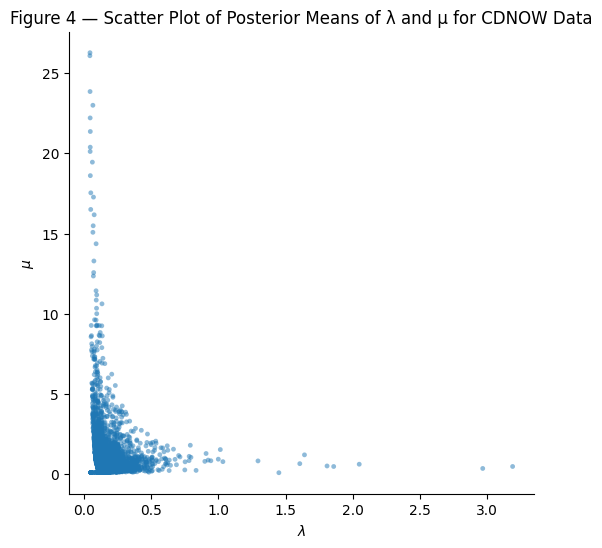

In [ ]:
# Inspect the posterior means of λ and μ
lam, mu = model.posterior_means()

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(lam, mu, s=12, alpha=0.5, edgecolor="none")     # pure scatter
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$\mu$")
ax.set_title("Figure 4 — Scatter Plot of Posterior Means of λ and μ for CDNOW Data")

sns.despine(fig)        
plt.show()

## Figure 5  – Distribution of Correlation Between log(λ) and log(μ) for CDNOW data

Text(0, 0.5, 'Frequency')

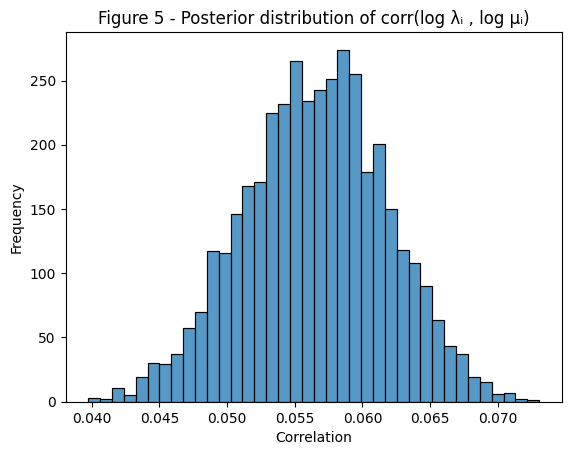

In [ ]:
# Posterior distribution of correlation between log λ and log μ
draws = np.stack(model.draws["theta"], axis=0)          # (n_draws, N, 2)

# one correlation per retained draw
corrs = [
    np.corrcoef(d[:, 0], d[:, 1])[0, 1]                 # d is (N, 2)
    for d in draws
]

sns.histplot(corrs)
plt.title("Figure 5 - Histogram of correlation between log(λ) and log(μ)")
plt.xlabel("Correlation")
plt.ylabel("Frequency")

## Table 1  Descriptive statistics for CDNOW Data

In [ ]:
# ------------------------------------------------------------
# 1.  Load the raw CDNOW master file (already cached earlier)
# ------------------------------------------------------------
raw = pd.read_csv(
    "~/.cache/cdnow_master.txt",
    sep=r"\s+",
    header=0,
    names=["id", "date", "qty", "spend"],
    parse_dates=["date"],
)

# calendar end of the study (same as Abe: 30 Jun 1998)
end_date = pd.Timestamp("1998-06-30")

# ------------------------------------------------------------
# 2.  Build per-customer aggregates
# ------------------------------------------------------------
first_txn = raw.groupby("id")["date"].min()
last_txn  = raw.groupby("id")["date"].max()
n_txn     = raw.groupby("id").size()
init_amt  = raw.sort_values("date").groupby("id")["spend"].first()

summary = pd.DataFrame({
    "Number of repeats"            : n_txn - 1,
    "Observation duration T (days)": (end_date - first_txn).dt.days,
    "Recency (T − t) (days)"       : (end_date - last_txn ).dt.days,
    "Amount of initial purchase ($)": init_amt,
})

# ------------------------------------------------------------
# 3.  Descriptive statistics (mean, sd, min, max)
# ------------------------------------------------------------
table1 = summary.agg(["mean", "std", "min", "max"]).T.round(2)
table1.columns = ["Mean", "Std. dev.", "Min", "Max"]

print(tabulate(table1, headers="keys", tablefmt="github"))

|                                |   Mean |   Std. dev. |   Min |     Max |
|--------------------------------|--------|-------------|-------|---------|
| Number of repeats              |   1.96 |        4.74 |     0 |  216    |
| Observation duration T (days)  | 502.09 |       23.31 |   462 |  545    |
| Recency (T − t) (days)         | 367.22 |      181.21 |     0 |  545    |
| Amount of initial purchase ($) |  32.79 |       33.17 |     0 | 1119.68 |


## Table 2  Model fit for CDNOW Data

In [33]:
# ------------------------------------------------------------------
# 0.  Imports & raw data -------------------------------------------
import numpy as np, pandas as pd
from lifetimes import ParetoNBDFitter
from tabulate import tabulate

# load CDNOW master file (cached by earlier steps or download once)
txn = pd.read_csv(
    "~/.cache/cdnow_master.txt",
    sep=r"\s+",
    header=0,
    names=["id", "date", "qty", "spend"],
    parse_dates=["date"],
)
txn["t_week"] = (txn["date"] - txn.groupby("id")["date"].transform("min")).dt.days // 7

# ------------------------------------------------------------------
# 1.  Per-customer RFM summary for calibration window (weeks 0-39) --
# ------------------------------------------------------------------
calib_weeks = 39
summary = (
    txn[txn["t_week"] <= calib_weeks]
      .groupby("id")
      .agg(
          frequency=("id", lambda x: len(x) - 1),   # repeat purchases
          recency  =("t_week", "max"),              # last txn week
          T        =("t_week", lambda x: calib_weeks),
      )
)

freq = summary["frequency"].values
reci = summary["recency"].values
Tarr = summary["T"].values

# ------------------------------------------------------------------
# 2.  Fit Pareto/NBD (population) ----------------------------------
pnbd = ParetoNBDFitter()
pnbd.fit(freq, reci*7, Tarr*7)   # lifetimes wants *days*

# ------------------------------------------------------------------
# 3.  Fit Hierarchical-Bayes models (uses your implementation) -----
from abe_hb_pareto_nbd import AbeHBParetoNBD

# ---- HB M1: no covariates
customers = [AbeHBParetoNBD.CustomerRFT(x=f, t_x=r, T=t, d=np.array([1.0]))
             for f, r, t in zip(freq, reci, Tarr)]

hb_m1 = AbeHBParetoNBD(customers, seed=42)
hb_m1.run_mcmc(14_000, burn_in=10_000, thin=1, proposal_scale=0.25, progress=False)

# ---- HB M2: add initial spend covariate
init_spend = (
    txn.sort_values("date")
        .groupby("id")["spend"].first()
        .reindex(summary.index)
        .values / 1000                    # scale like Abe
)
customers_cov = [
    AbeHBParetoNBD.CustomerRFT(x=f, t_x=r, T=t, d=np.array([1.0, s]))
    for f, r, t, s in zip(freq, reci, Tarr, init_spend)
]
hb_m2 = AbeHBParetoNBD(customers_cov, seed=123)
hb_m2.run_mcmc(14_000, burn_in=10_000, thin=1, proposal_scale=0.25, progress=False)

# ------------------------------------------------------------------
# 4.  Helper to compute expected repeats for HB models -------------
def expected_repeats(hb_model, weeks_vec):
    lam, mu = hb_model.posterior_means()
    w = np.asarray(weeks_vec, dtype=float)
    return (lam[:, None] / mu[:, None]) * (1 - np.exp(-mu[:, None] * w))

# ------------------------------------------------------------------
# 5.  Individual-level metrics (corr, MSE) -------------------------
def indiv_metrics(exp_val, act_val, exp_cal, act_cal):
    c_val = np.corrcoef(exp_val, act_val)[0, 1]
    c_cal = np.corrcoef(exp_cal, act_cal)[0, 1]
    mse_v = np.mean((exp_val - act_val) ** 2)
    mse_c = np.mean((exp_cal - act_cal) ** 2)
    return c_val, c_cal, mse_v, mse_c

# actual counts
act_cal = (
    txn[txn["t_week"] <= 39]
      .groupby("id").size()
      .reindex(summary.index, fill_value=0)
      .values
)
act_val = (
    txn[(txn["t_week"] > 39) & (txn["t_week"] <= 52)]
      .groupby("id").size()
      .reindex(summary.index, fill_value=0)
      .values
)

# Pareto/NBD expectations per customer
exp_cal_pn = pnbd.conditional_expected_number_of_purchases_up_to_time(39*7, freq, reci*7, Tarr*7)
exp52      = pnbd.conditional_expected_number_of_purchases_up_to_time(52*7, freq, reci*7, Tarr*7)
exp_val_pn = exp52 - exp_cal_pn
c_v_pn, c_c_pn, mse_v_pn, mse_c_pn = indiv_metrics(exp_val_pn, act_val, exp_cal_pn, act_cal)

# HB M1 expectations
exp_cal_m1 = expected_repeats(hb_m1, 39)
exp_val_m1 = expected_repeats(hb_m1, 13)
c_v_m1, c_c_m1, mse_v_m1, mse_c_m1 = indiv_metrics(exp_val_m1, act_val, exp_cal_m1, act_cal)

# HB M2 expectations
exp_cal_m2 = expected_repeats(hb_m2, 39)
exp_val_m2 = expected_repeats(hb_m2, 13)
c_v_m2, c_c_m2, mse_v_m2, mse_c_m2 = indiv_metrics(exp_val_m2, act_val, exp_cal_m2, act_cal)

# ------------------------------------------------------------------
# 6.  Aggregate MAPE (validation / calibration / pooled) ----------
weeks = np.arange(0, 53)
actual_cum = (
    txn[txn["t_week"] <= 52]
      .groupby("t_week").size()
      .reindex(weeks, fill_value=0)
).cumsum()

def cum_curve_pnbd():
    return np.array([pnbd.conditional_expected_number_of_purchases_up_to_time(
                        w*7, freq, reci*7, Tarr*7).sum() for w in weeks])

def cum_curve_hb(hb_model):
    lam, mu = hb_model.posterior_means()
    return ((lam/mu)[:,None]*(1-np.exp(-mu[:,None]*weeks))).sum(axis=0)

cum_pn  = cum_curve_pnbd()
cum_m1  = cum_curve_hb(hb_m1)
cum_m2  = cum_curve_hb(hb_m2)

def mape(curve, start, end):
    slice_act = actual_cum[start:end]
    slice_pred = curve[start:end]
    return np.mean(np.abs(slice_pred - slice_act) / slice_act.replace(0, np.nan)) * 100

mape_val_pn, mape_cal_pn = mape(cum_pn, 40, None), mape(cum_pn, 0, 40)
mape_val_m1, mape_cal_m1 = mape(cum_m1, 40, None), mape(cum_m1, 0, 40)
mape_val_m2, mape_cal_m2 = mape(cum_m2, 40, None), mape(cum_m2, 0, 40)

# pooled MAPE
mape_pool_pn = mape(cum_pn, 0, None)
mape_pool_m1 = mape(cum_m1, 0, None)
mape_pool_m2 = mape(cum_m2, 0, None)

# ------------------------------------------------------------------
# 7.  Assemble Table 2 ---------------------------------------------
table2 = pd.DataFrame({
    "Criterion": [
        "Correlation: Validation", "Correlation: Calibration",
        "MSE: Validation", "MSE: Calibration",
        "MAPE (%): Validation", "MAPE (%): Calibration", "MAPE (%): Pooled"
    ],
    "Pareto/NBD": [
        c_v_pn, c_c_pn, mse_v_pn, mse_c_pn,
        mape_val_pn, mape_cal_pn, mape_pool_pn
    ],
    "HB M1\n(no covariate)": [
        c_v_m1, c_c_m1, mse_v_m1, mse_c_m1,
        mape_val_m1, mape_cal_m1, mape_pool_m1
    ],
    "HB M2\n(with covariate)": [
        c_v_m2, c_c_m2, mse_v_m2, mse_c_m2,
        mape_val_m2, mape_cal_m2, mape_pool_m2
    ],
}).set_index("Criterion").round(2)

print(tabulate(table2, headers="keys", tablefmt="github"))

AttributeError: type object 'AbeHBParetoNBD' has no attribute 'CustomerRFT'

## Table 3 Estimation Results for CDNOW Data

## Table 4 Customer-Specific Statistics for the Top and Bottom 10 Customers